In [1]:
import numpy as np
import torch
import sklearn

# visualization
import seaborn
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner

%load_ext autoreload
%autoreload 2

In [2]:
import lbi.models
from lbi.nde import NeuralRatioEstimator, NeuralLikelihoodEstimator
from lbi.sequential import Sequential

In [3]:
import dataset
import sklearn.preprocessing

N = 30000

scaler = sklearn.preprocessing.StandardScaler().fit(dataset.obs)
param_scaler = sklearn.preprocessing.StandardScaler().fit(dataset.params)

param_dim = dataset.params.shape[-1]
obs_dim = dataset.obs.shape[-1]
observation = torch.tensor([[np.log(0.12), 118.]])

/media/jt/data/Projects/MSSM/datasets/Hollingsworth/read_dataset.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['chg2'][np.where(np.isnan(f['chg2']))[0]]=-1


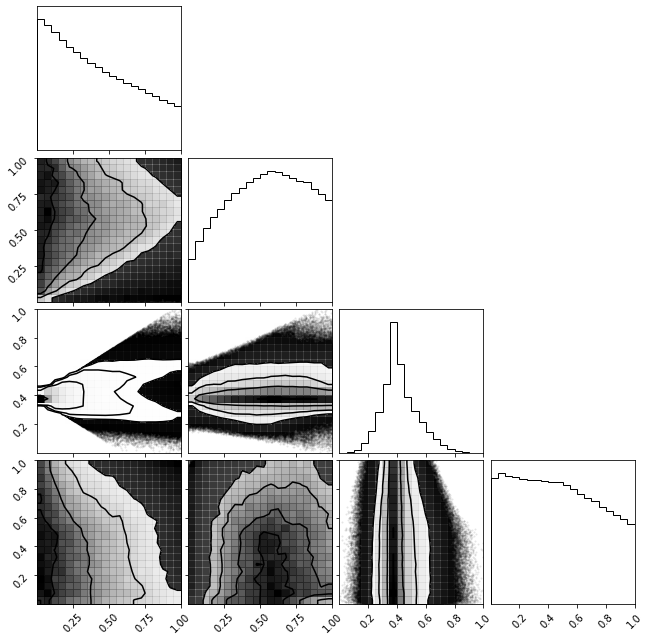

In [4]:
corner.corner(dataset.params.numpy());

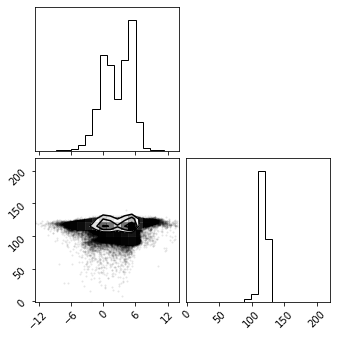

In [5]:
corner.corner(dataset.obs.numpy());

In [6]:
# Make multivariate uniform prior distribution
priors = torch.distributions.Independent(torch.distributions.Uniform(low=torch.zeros(param_dim), 
                                                                     high=torch.ones(param_dim)), 
                                         reinterpreted_batch_ndims=1)

In [7]:
width = 128
x_dim = obs_dim + param_dim

layers = [['ResBlock', x_dim], ['SELU'], 
          ['ResBlock', x_dim*2], ['SELU'], 
          ['ResBlock', x_dim*4], ['SELU'], 
#           ['ResBlock', x_dim*3], ['SELU'], 
#           ['ResBlock', x_dim*4], ['SELU'], 
#           ['Linear', width, width], ['SELU'], 
          ['Linear', x_dim*8, width], ['SELU'], 
          ['Linear', width, 1]]
model = lbi.models.Classifier(layers=layers)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
nre = NeuralRatioEstimator(model)

In [8]:
snre = Sequential(priors=priors, 
                  obs_data=observation, 
                  param_dim=param_dim, 
                  model=nre, 
                  optimizer=optimizer, 
                  scaler=scaler, 
                  param_scaler=param_scaler,
                  log_dir='.',
                  simulator=None, 
                  progress=True,
                  max_n_epochs=1000,
                  patience=2500,
                  n_rounds=1)

In [9]:
# Store data
print("Adding sims to sequential object")
snre.add_data(dataset.obs[:N], dataset.params[:N])

Adding sims to sequential object


In [10]:
global_step = 0
print("Training model")
try:
    global_step = snre.train(global_step=global_step)
except KeyboardInterrupt:
    pass

snre.model.eval();

  0%|          | 0/1000 [00:00<?, ?it/s]

Training model
Training on 25,500 samples. Validating on 4,500 samples.


Validation Loss: 0.959: 100%|██████████| 1000/1000 [08:15<00:00,  2.02it/s]


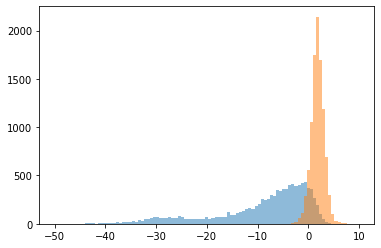

In [11]:
n_data = 10000
with torch.no_grad():
    true_lps = snre.model.forward(snre.data['train_data'][:n_data], snre.data['train_params'][:n_data])
    false_lps = snre.model.forward(snre.data['train_data'][:n_data], snre.data['train_params'][torch.randperm(n_data)])

_, bins, _ = plt.hist(false_lps.numpy(), alpha=0.5, label='false log prob', bins=np.linspace(-50, 10, 100))
plt.hist(true_lps.numpy(), alpha=0.5, bins=bins, label='true log prob')
plt.show()

In [13]:
import emcee

ModuleNotFoundError: No module named 'emcee'

In [12]:
posterior_samples = snre.hmc(num_samples=200000, walker_steps=10000, burn_in=6000)

Warmup:   0%|          | 0/16000 [00:00, ?it/s]

ValueError: 

In [ ]:
corner.corner(posterior_samples.numpy(), 
              range=[(0, 1) for i in range(param_dim)], 
              smooth=0.1,
             );

In [ ]:
posterior_samples = snre.hmc(num_samples=200000, walker_steps=5000, burn_in=2500)

In [ ]:
corner.corner(posterior_samples.numpy(), 
              range=[(0, 1) for i in range(param_dim)], 
              smooth=0.1,
             );